In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import itertools as it
import pdb
import matplotlib

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.rcParams.update({'font.size': 17})

In [2]:
def collect_experiment_to_df(fpath="expt_logs/"):
    #Reading all the experiments file
    expt_fname_list = glob.glob(fpath+"*.json")
    
    #Now we will create a dataframe out of it
    expt_metric_list = []
    for fname in expt_fname_list:
        #Loading the experiment json file
        with open(fname) as f:
            expt_json = json.load(f)
        
        #Next we will load the necessary metrics from json for analysis
        expt_metric_dict = dict(
                    num_nodes = expt_json["expt_args"]["num_nodes"],
                    num_samples = expt_json["expt_args"]["mix_samples"],
                    cutoff_drop_ratio = expt_json["expt_args"]["cutoff_drop_ratio"] if "cutoff_drop_ratio" in expt_json["expt_args"] else None,
#                     intv_targets = expt_json["expt_args"]["intv_targets"],
                    adj_dense_prop = expt_json["expt_args"]["adj_dense_prop"],
                    new_noise_mean = expt_json["expt_args"]["new_noise_mean"],
                    new_noise_var = expt_json["expt_args"]["new_noise_var"],
#                     obs_noise_gamma_shape = expt_json["expt_args"]["obs_noise_gamma_shape"],
                    param_est_rel_err = expt_json["metric_dict"]["param_est_rel_err"],
                    est_num_comp = expt_json["metric_dict"]["est_num_comp"] if "est_num_comp" in expt_json["metric_dict"] else None,
                    weight_precision_error = expt_json["metric_dict"]["weight_precision_error"],
                    shd = expt_json["metric_dict"]["shd"],
                    oracle_shd = expt_json["metric_dict"]["oracle_shd"],
                    intv_base_shd = expt_json["metric_dict"]["intv_base_shd"] if "intv_base_shd" in expt_json["metric_dict"] else None,
#                     igsp_shd = expt_json["metric_dict"]["igsp_shd"],
                    avg_js = expt_json["metric_dict"]["avg_js"],
                    avg_oracle_js = expt_json["metric_dict"]["avg_oracle_js"],
#                     avg_intv_base_js = expt_json["metric_dict"]["avg_intv_base_js"],
#                     act_dag = expt_json["metric_dict"]["act_dag"],
#                     est_dag = expt_json["metric_dict"]["est_dag"],
#                     oracle_est_dag = expt_json["metric_dict"]["oracle_est_dag"],
        )
        expt_metric_list.append(expt_metric_dict)
    
    #Now we will create a dataframe out of it
    expt_df = pd.DataFrame(expt_metric_list)
    return expt_df


def merge_df_multiple_expt(expt_fname_list):
    all_expt_df = []
    for expt_fname in expt_fname_list:
        expt_df = collect_experiment_to_df(fpath=expt_fname)
        all_expt_df.append(expt_df)
    #Concatenating all the df
    all_expt_df = pd.concat(all_expt_df,ignore_index=True,sort=False)
    return all_expt_df

## Plot utilities

In [3]:
'''
Expt LOG: Tracks changes that happened corresponding to last experiment state

expt_logs_29.04.24-2 : with max-stegngth = 10, 30-50 random runs,init noise mean=1.0, new noise mean=10.0
expt_logs_29.04.24-3 : with max-stegngth = 20, 10 random runs
expt_logs_29.04.24-4 : with max-stegngth = 30
expt_logs_29.04.24-5 : with max-stegngth = 1 (better)
expt_logs_29.04.24-6 : with max-stegngth = 1, lowlim = 0.2*max-strength, (4,6,8 nodes) (better) 
expt_logs_29.04.24-7 : with max-stegngth = 1, lowlim = 0.5*max-strength, (slightly worse for 6, but JS good)
expt_logs_29.04.24-8 : with max-stegngth = 10, lowlim = 0.5*max-strength,
expt_logs_29.04.24-9 : with max-stegngth = 1, lowlim = 0.5*max-strength, no relative error now,
expt_logs_29.04.24-10 : with max-stegngth = 1, lowlim = 0.5*max-strength, init noise mean=0.0
expt_logs_29.04.24-11 : with max-stegngth = 1, lowlim = 0.5*max-strength, new noise mean=1.0
expt_logs_29.04.24-tol : with max-stegngth = 1, lowlim = 0.5*max-strength, new noise mean=1.0, node=9,10,11, tol=10000,5000,1000


expt_logs_30.04.24-test : Redoing expt_logs_29.04.24-11 after the new way to control sparsity
expt_logs_30.04.24-sp   : sparsity using the probability (p=0-1) [0.0,0.1,0.4,0.8,0.9,0.92,0.96,1.0]
expt_logs_30.04.24-allunk: when we have all the component in the mixture (including obs), otherwise same as test above
expt_logs_30.04.24-spallunk: TODO
expt_logs_30.04.24-noise-shift : shifting the noise ([1.0,2.0,4.0,10.0,]) in sp setting with p=0.8, n=6
expt_logs_30.04.24-hard : hard intervention with new mean shift [0.0 (actual in obs),1.0] and new sigma shift in [0.1,1.0,2.0,8.0] 



expt_logs_11.05.24-main_plus_oracle : oracle-utgsp is given exact parameters to recover target and graph (ow same as expt_logs_30.04.24-test)


Ideas:
1. Relative error might be creating problem. What if we remove relative atleast and see absolute or change mean
2. Check the quantile problem!
'''

'\nExpt LOG: Tracks changes that happened corresponding to last experiment state\n\nexpt_logs_29.04.24-2 : with max-stegngth = 10, 30-50 random runs,init noise mean=1.0, new noise mean=10.0\nexpt_logs_29.04.24-3 : with max-stegngth = 20, 10 random runs\nexpt_logs_29.04.24-4 : with max-stegngth = 30\nexpt_logs_29.04.24-5 : with max-stegngth = 1 (better)\nexpt_logs_29.04.24-6 : with max-stegngth = 1, lowlim = 0.2*max-strength, (4,6,8 nodes) (better) \nexpt_logs_29.04.24-7 : with max-stegngth = 1, lowlim = 0.5*max-strength, (slightly worse for 6, but JS good)\nexpt_logs_29.04.24-8 : with max-stegngth = 10, lowlim = 0.5*max-strength,\nexpt_logs_29.04.24-9 : with max-stegngth = 1, lowlim = 0.5*max-strength, no relative error now,\nexpt_logs_29.04.24-10 : with max-stegngth = 1, lowlim = 0.5*max-strength, init noise mean=0.0\nexpt_logs_29.04.24-11 : with max-stegngth = 1, lowlim = 0.5*max-strength, new noise mean=1.0\nexpt_logs_29.04.24-tol : with max-stegngth = 1, lowlim = 0.5*max-strength, 

In [3]:
#Defining the custom percentile function
def quantile25(x):
    return x.quantile(0.05)
def quantile75(x):
    return x.quantile(0.95)

In [75]:
expt_name = "expt_lofs_sachs-middleout_all_obs_oracle_corr"
expt_fpath_list= ["all_expt_logs/{}/".format(expt_name)]
expt_df = merge_df_multiple_expt(expt_fpath_list)

single_expt = expt_df[expt_df["num_samples"]==4200].iloc[0]
act_dag = single_expt["act_dag"]
est_dag = single_expt["est_dag"]
oracle_est_dag = single_expt["oracle_est_dag"]

In [87]:
print(act_dag)

{'amat': [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'nodes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


In [88]:
0=Raf, 1=Mek , 2=PLCg, 3=PIP2	, 4=PIP3, 5=Erk, 6=Akt	, 7=PKA, 8=PKC, 9=p38, 10=JNK

SyntaxError: cannot assign to literal (2379175181.py, line 1)

In [106]:
expt_name = "expt_logs_sim_compsel_n48"
expt_fpath_list= ["all_expt_logs/{}/".format(expt_name)]
expt_df = merge_df_multiple_expt(expt_fpath_list)

expt_df.head()

,num_nodes,num_samples,intv_targets,param_est_rel_err,est_num_comp,shd,oracle_shd,intv_base_shd,avg_js,avg_oracle_js
0,8,2048,"[4, 5, 1, 2]",57.043567,3,12,15,None,None,None
1,8,131072,"[5, 6, 3, 1]",3.469782,5,11,0,None,None,None
2,4,8192,"[3, 0]",1.243162,3,0,0,None,None,None
3,8,8192,"[2, 6, 0, 7]",29.264152,5,16,16,None,None,None
4,4,262144,"[2, 3]",0.165730,3,1,0,None,None,None


## Plotting the variation with node size (Main)

[]

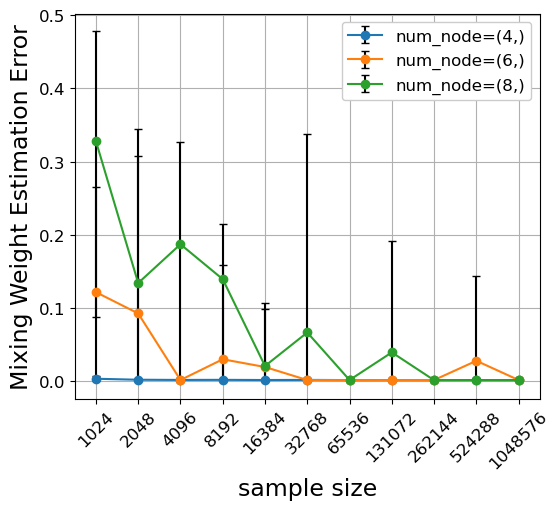

In [73]:
plot_metric_list = [
#                     ("param_est_rel_err",0,"Parameter Estimation Error"),
#                     ("est_num_comp",0,"#Estimated Component")
                    ("weight_precision_error",0,"Mixing Weight Estimation Error")
#                     ("avg_js",1,"Average Jaccard Similarity"),
#                     ("avg_oracle_js",1,"Average Jaccard Similarity"),
#                     ("avg_intv_base_js",1,"Average Jaccard Similarity"),
#                     ("shd",2,"SHD"),
#                     ("oracle_shd",2,"SHD"),
#                     ("intv_base_shd",2,"SHD"),
#                     ("igsp_shd",2,"SHD"),
]

ncols = 1
plt.rcParams['figure.figsize'] = [6*ncols,5]
fig,ax = plt.subplots(nrows=1,ncols=ncols)
oracle_ls = {4:"-.",6:":",8:"--",12:"-.",15:":",20:"--",11:"-."}


#SElf selection experiment
# expt_name = "expt_logs_sim_compsel_n48" 
# expt_name2 = "expt_logs_sim_compsel_n12"
# expt_name = "expt_logs_sim_compsel_n48-all"
# expt_name = "expt_logs_sim_compsel_n48_bic-half"
# expt_name = "expt_logs_sim_compsel_n48_middleout_oracle_corr-half2" #contains only backward selection node 4 and 8
# expt_name2 = "expt_logs_sim_compsel_n48_middleout_oracle_corr-half6_actual"# back and node 6

# expt_name = "expt_logs_sim_compsel_n48_middleout_oracle_corr-half6" #the result for all 4,6,8 got overwritten here


#Cameraready version
expt_name = "expt_logs_sim_compsel_backward_cameraready_all_re" #for tha all intervention setting
# expt_name = "expt_logs_sim_compsel_backward_cameraready_half"



#OLD to compare
# expt_name = "expt_logs_11.05.24-half_intv_weight_error_all_comp_utigsp_large_sample"


#Real World- SACHS
# expt_name = "expt_lofs_sachs-re6"
# expt_name = "expt_lofs_sachs-middleout_all_obs_oracle_corr_bic"
# expt_name = "expt_lofs_sachs-middleout_all_obs_oracle_corr"


expt_fpath_list= ["all_expt_logs/{}/".format(expt_name),]
# expt_fpath_list= ["all_expt_logs/{}/".format(expt_name)]
expt_df = merge_df_multiple_expt(expt_fpath_list)

for num_node,node_df in expt_df.groupby(["num_nodes"]):
    #Getting the mean and std for this dataframe
    node_df_mean = node_df.groupby("num_samples").mean()
    node_df_std = node_df.groupby("num_samples").std()
    node_df_q25 = node_df.groupby("num_samples").aggregate(quantile25)
    node_df_q75 = node_df.groupby("num_samples").aggregate(quantile75)
    
    
    #Now plotting the variation across samples for each of the param
    for metric,midx,metric_name in plot_metric_list:
        sample_size = np.array(list(node_df_mean.index))
        metric_mean = np.array(node_df_mean[metric].tolist())
        metric_std = np.array(node_df_std[metric].tolist())
        
        low_yerr = metric_mean - np.array(node_df_q25[metric].tolist())
        high_yerr = np.array(node_df_q75[metric].tolist())-metric_mean
        
#         low_yerr = metric_mean - metric_std
#         high_yerr = metric_mean + metric_std
        
#         if np.sum(low_yerr<0)>0:
#             pdb.set_trace()
#         elif np.sum(high_yerr<0)>0:
#             pdb.set_trace()
        
        
        #CHECK: mean should have been above 25 and below 75, something might be wrong
        q25_75 = [
                    low_yerr*(low_yerr>=0), 
                    high_yerr*(high_yerr>=0)
        ]
        
        
        #ax[midx].plot(range(len(sample_size)),metric_mean,)
        if "oracle" in metric or "intv_base" in metric:
            ax.errorbar(range(len(sample_size)),
                                  metric_mean,
#                                   yerr=q25_75,
                                  ls=oracle_ls[num_node[0]],
                                  color="black",
#                                   capsize=3,
                                  ecolor = "black",
                                  label="oracle:num_node={}".format(num_node)
            )
        elif "igsp" in metric:
            ax.errorbar(range(len(sample_size)),
                                  metric_mean,
#                                   yerr=q25_75,
                                  ls=oracle_ls[num_node[0]],
                                  color="red",
#                                   capsize=3,
                                  ecolor = "black",
                                  label="igsp".format(num_node)
            )
        else:
            ax.errorbar(range(len(sample_size)),
                                  metric_mean,
                                  yerr=q25_75,
                                  capsize=3,
                                  ecolor = "black",
                                  fmt="-o",
                                  label="num_node={}".format(num_node)
            )
#         ax.set_title("Metric = {}".format(metric))
        ax.set_ylabel(metric_name)
        ax.set_xlabel("sample size")
        ax.set_xticks(range(len(sample_size)))
        ax.set_xticklabels(sample_size,rotation=45)
        ax.legend(prop={'size': 12},framealpha=1.0)
        ax.grid(True)
plt.savefig('{}-{}.pdf'.format(metric,expt_name), bbox_inches='tight')
plt.plot()

In [67]:
expt_df.head()

,num_nodes,num_samples,cutoff_drop_ratio,adj_dense_prop,param_est_rel_err,est_num_comp,shd,oracle_shd,intv_base_shd,avg_js,avg_oracle_js
0,4,2048,0.07,0.8,3.996443,None,2,5,None,0.600000,0.433333
1,4,32768,0.07,0.8,1.310118,None,0,0,None,0.800000,0.800000
2,6,131072,0.07,0.8,3.639103,None,0,0,None,0.785714,0.857143
3,6,131072,0.07,0.8,2.631088,None,0,0,None,0.857143,0.857143
4,8,8192,0.07,0.8,227.748582,None,6,7,None,0.407407,0.518519


## Plotting for the case we have interventional dist as base

[]

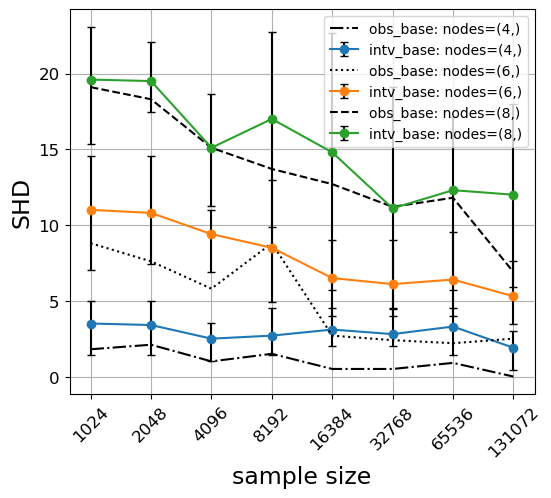

In [6]:
plot_metric_list = [
#                     ("param_est_rel_err",0,"Parameter Estimation Error"),
#                     ("weight_precision_error",3,"Mixing Weight Estimation Error")
#                     ("avg_js",1,"Average Jaccard Similarity"),
#                     ("avg_oracle_js",1,"Average Jaccard Similarity"),
#                     ("avg_intv_base_js",1,"Average Jaccard Similarity"),
                    ("shd",2,"SHD"),
#                     ("oracle_shd",2,"SHD"),
                    ("intv_base_shd",2,"SHD"),
]

ncols = 1
plt.rcParams['figure.figsize'] = [6*ncols,5]
fig,ax = plt.subplots(nrows=1,ncols=ncols)
oracle_ls = {4:"-.",6:":",8:"--",12:"-.",15:":",20:"--"}

# expt_name = "expt_logs_11.05.24-main_plus_oracle_donoisepert-corr-js" #: Last Active (Full Main)
# expt_name = "expt_logs_11.05.24-half_intv" #: Last Active (Half Main)
# expt_name = "expt_logs_11.05.24-unequal_matching" #: Active (Appendix)
# expt_name = "expt_logs_11.05.24-large_nodes_sparse_intv" #: Active (Appendix)
expt_name = "expt_logs_11.05.24-main_plus_oracle_donoisepert-corr-js"


# expt_name = "expt_logs_11.05.24-half_intv_weight_error_all_comp_utigsp" : Can leave test
# expt_name = "expt_logs_11.05.24-half_intv_weight_error_all_comp_utigsp_large_sample" #Current Active
# expt_name = "expt_logs_11.05.24-all_intv_weight_error_all_comp_utigsp_large_sample" #Current Active

expt_fpath_list= ["all_expt_logs/{}/".format(expt_name)]
expt_df = merge_df_multiple_expt(expt_fpath_list)

for num_node,node_df in expt_df.groupby(["num_nodes"]):
    #Getting the mean and std for this dataframe
    node_df_mean = node_df.groupby("num_samples").mean()
    node_df_std = node_df.groupby("num_samples").std()
    node_df_q25 = node_df.groupby("num_samples").aggregate(quantile25)
    node_df_q75 = node_df.groupby("num_samples").aggregate(quantile75)
    
    
    #Now plotting the variation across samples for each of the param
    for metric,midx,metric_name in plot_metric_list:
        sample_size = np.array(list(node_df_mean.index))
        metric_mean = np.array(node_df_mean[metric].tolist())
        metric_std = np.array(node_df_std[metric].tolist())
        
        low_yerr = metric_mean - np.array(node_df_q25[metric].tolist())
        high_yerr = np.array(node_df_q75[metric].tolist())-metric_mean
        
#         low_yerr = metric_mean - metric_std
#         high_yerr = metric_mean + metric_std
        
#         if np.sum(low_yerr<0)>0:
#             pdb.set_trace()
#         elif np.sum(high_yerr<0)>0:
#             pdb.set_trace()
        
        
        #CHECK: mean should have been above 25 and below 75, something might be wrong
        q25_75 = [
                    low_yerr,#*(low_yerr>=0), 
                    high_yerr,#*(high_yerr>=0)
        ]
        
        
        #ax[midx].plot(range(len(sample_size)),metric_mean,)
        if "intv_base" in metric:
            ax.errorbar(range(len(sample_size)),
                                  metric_mean,
                                  yerr=q25_75,
                                  capsize=3,
                                  ecolor = "black",
                                  fmt="-o",
                                  label="intv_base: nodes={}".format(num_node)
            )
        elif "oracle" in metric:
            raise NotImplementedError()
        else:
            ax.errorbar(range(len(sample_size)),
                                  metric_mean,
#                                   yerr=q25_75,
                                  ls=oracle_ls[num_node[0]],
                                  color="black",
#                                   capsize=3,
                                  ecolor = "black",
                                  label="obs_base: nodes={}".format(num_node)
            )
#         ax.set_title("Metric = {}".format(metric))
        ax.set_ylabel(metric_name)
        ax.set_xlabel("sample size")
        ax.set_xticks(range(len(sample_size)))
        ax.set_xticklabels(sample_size,rotation=45)
        ax.legend(prop={'size': 10})
        ax.grid(True)
plt.savefig('{}-{}.pdf'.format(metric,expt_name), bbox_inches='tight')
plt.plot()

## Plotting the variation with the sparsity pattern (n=6)

[]

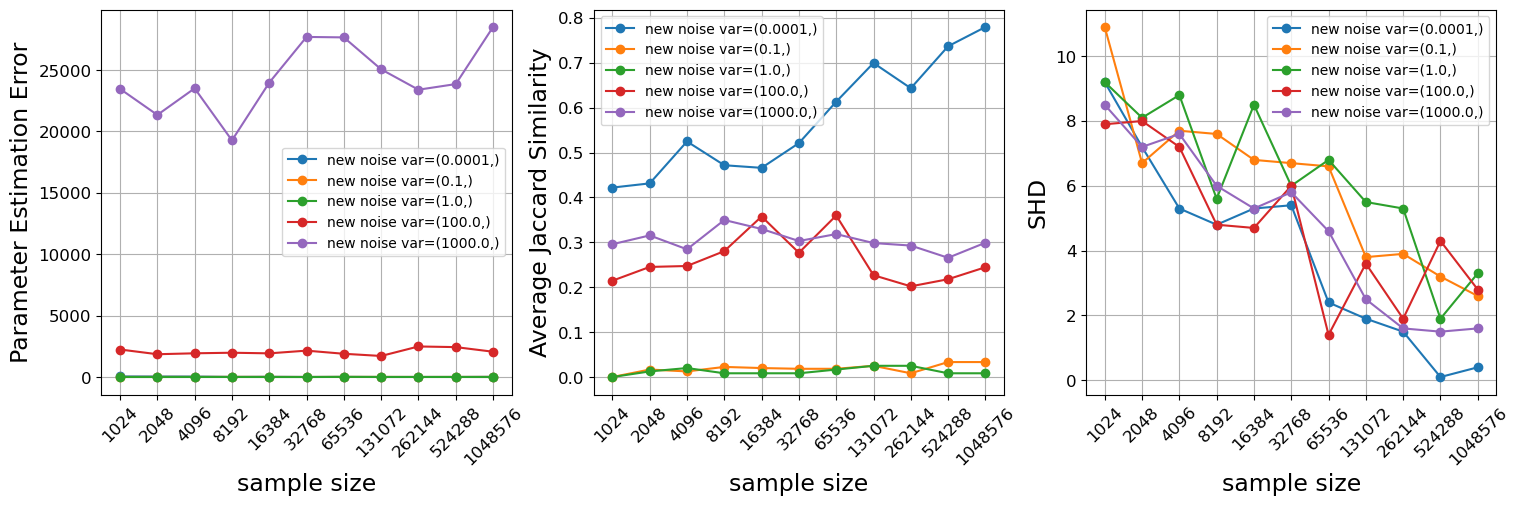

In [10]:
# expt_name = "expt_logs_11.05.24-sparsity_n6-corr"
# attribute1_list_to_plot = [0.1,0.4,0.6,1.0]
# group_attribute_list = ["adj_dense_prop"] #"adj_dense_prop"
# group_arrribute_list_names = ["graph density"]

# expt_name = "expt_logs_11.05.24-mean_shift-corr"
# expt_name = "expt_logs_sim_compsel_backward_cameraready_new_mean"
# attribute1_list_to_plot = [0.1,0.2,0.5,1.0]
# group_attribute_list = ["new_noise_mean"]
# group_arrribute_list_names = ["new noise mean"]

# expt_name = "expt_logs_11.05.24-hard_var_shift-corr"
expt_name = "expt_logs_sim_compsel_backward_cameraready_new_var_largerange"
attribute1_list_to_plot = [1e-4,1e-1,1.0,100,1000]
group_attribute_list = ["new_noise_var"]
group_arrribute_list_names = ["new noise var"]



# expt_name = "expt_logs_sim_compsel_backward_cameraready_cutoff_var_half"
# attribute1_list_to_plot = [0.01,0.15,0.3,0.6]
# group_attribute_list = ["cutoff_drop_ratio"]
# group_arrribute_list_names = ["cutoff ratio"]




expt_fpath_list= [
                "all_expt_logs/{}/".format(expt_name)
]
expt_df = merge_df_multiple_expt(expt_fpath_list)


attribute2_list_to_plot = [None] #0.1,1.0,2.0,8.0
plot_metric_list = [
                    (0,"param_est_rel_err","Parameter Estimation Error"),
                    (1,"avg_js","Average Jaccard Similarity"),
                    (2,"shd","SHD"),
                   ]



plt.rcParams['figure.figsize'] = [6*len(plot_metric_list),5]
fig,ax = plt.subplots(nrows=1, ncols=len(plot_metric_list))


for aval,node_df in expt_df.groupby(group_attribute_list):
    if aval[0] not in attribute1_list_to_plot:
        continue
    if len(group_attribute_list)>1 and aval[1] not in attribute2_list_to_plot:
        continue
    
    #Getting the mean and std for this dataframe
    node_df_mean = node_df.groupby("num_samples").mean()
    node_df_std = node_df.groupby("num_samples").std()
    node_df_q25 = node_df.groupby("num_samples").aggregate(quantile25)
    node_df_q75 = node_df.groupby("num_samples").aggregate(quantile75)
    
    
    #Now plotting the variation across samples for each of the param
    for midx,metric,metric_name in plot_metric_list:
        sample_size = np.array(list(node_df_mean.index))
        metric_mean = np.array(node_df_mean[metric].tolist())
        metric_std = np.array(node_df_std[metric].tolist())
        
        low_yerr = metric_mean - np.array(node_df_q25[metric].tolist())
        high_yerr = np.array(node_df_q75[metric].tolist())-metric_mean
        #CHECK: mean should have been above 25 and below 75, something might be wrong
        q25_75 = [
                    low_yerr,#*(low_yerr>=0), 
                    high_yerr,#*(high_yerr>=0)
        ]
        
        
        #ax[midx].plot(range(len(sample_size)),metric_mean,)
        ax[midx].errorbar(range(len(sample_size)),
                              metric_mean,
#                               yerr=q25_75,
#                               capsize=3,
#                               ecolor = "black",
                              fmt="-o",
                              label="{}={}".format(group_arrribute_list_names[0],aval)
        )
        
#         ax[midx].set_title("Metric = {}".format(metric))
        ax[midx].set_ylabel(metric_name)
        ax[midx].set_xlabel("sample size")
        ax[midx].set_xticks(range(len(sample_size)))
        ax[midx].set_xticklabels(sample_size,rotation=45)
        ax[midx].legend(prop={'size': 10})
        ax[midx].grid(True)
plt.savefig('{}.pdf'.format(expt_name), bbox_inches='tight')
plt.plot()